In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'california-housing-prices:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5227%2F7876%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240222%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240222T193351Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D80391d22de4d87259ba509311ab1c03f777315e5e3b82e74aaf465c6a0f7820b7053303d10e2741f433f76fdda31df22d4e5c9a7186acabb2a9ed0091c7dbbb53aae7fc4f350926623ea696161ee9867f5bef01d81629d31b8770fed0fa3b1bf986334256351455e406795d8c2cd5aa589f4d0c1aeb3b9a447d42d2cd45bf06f5797b9808bd3a15a0239ac46b4b57440f8bec650845659a5ce11302cca7044c61b564da6865fc8dea8bc5cb113d7f81f12d2d4fe6dc494d1b616224a55a4fc3875cca8264566be6a8cebac0a016225c30069c25d862cccbc5c59a585d0ac6e34bec344f5c7e6d548e9be86354f58384ea23627da0564b6f1c42540c9312e900d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/california-housing-prices/housing.csv


In [ ]:
df = pd.read_csv("/kaggle/input/california-housing-prices/housing.csv")


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from pandas.plotting import scatter_matrix
from sklearn.ensemble import RandomForestRegressor


import seaborn as sns
import matplotlib.pyplot as plt
import inspect

In [ ]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [ ]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [ ]:
df.isna().sum()
df.ocean_proximity.unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [ ]:
total_bedroom = df.total_bedrooms

In [ ]:
print(total_bedroom[total_bedroom.isna()])
# replace total bedrooms NaN values with there median value
median = total_bedroom.median()
print(f"median is :{median}")
total_bedroom.fillna(total_bedroom.median(),inplace = True)
print(f"the NAN values in total_bedroom now is :{total_bedroom.isna().sum()}")
# or total_bedroom.fillna(total_bedroom.median(),inplace = True) to do the same in one line


290     NaN
341     NaN
538     NaN
563     NaN
696     NaN
         ..
20267   NaN
20268   NaN
20372   NaN
20460   NaN
20484   NaN
Name: total_bedrooms, Length: 207, dtype: float64
median is :435.0
the NAN values in total_bedroom now is :0


<Axes: >

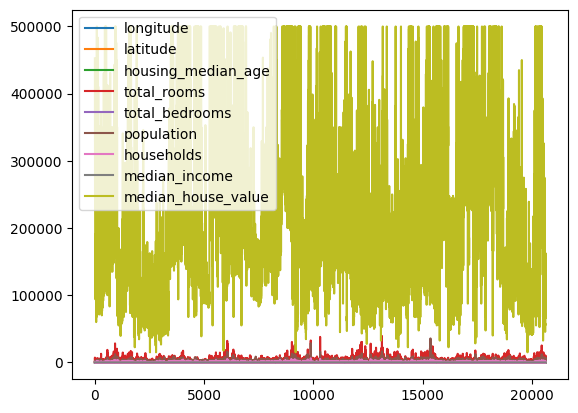

In [ ]:

df.plot()


#  first i need to scale the  data , for that either i will use scikit-learn preprocessor or i can scale it by writing 4-5 line code

In [ ]:


scaler = StandardScaler()

numeric_df = df.copy()
numeric_df.drop(columns =['ocean_proximity'],inplace = True)

# scaled_numeric_data = scaler.fit_transform(numeric_df)
# SINCE THE VALUES FOR HOUSE VALUE WAS COMING NEGATIVE BY USING STANDARD SCALAR METHOD I WILL USE NORMALIZATION


scaled_numeric_data = scaler.fit_transform(numeric_df)


scaled_numeric_data = pd.DataFrame(scaled_numeric_data,columns = numeric_df.columns)


Text(0.5, 1.0, 'Heat_Map_Of_Correlation_Matrix')

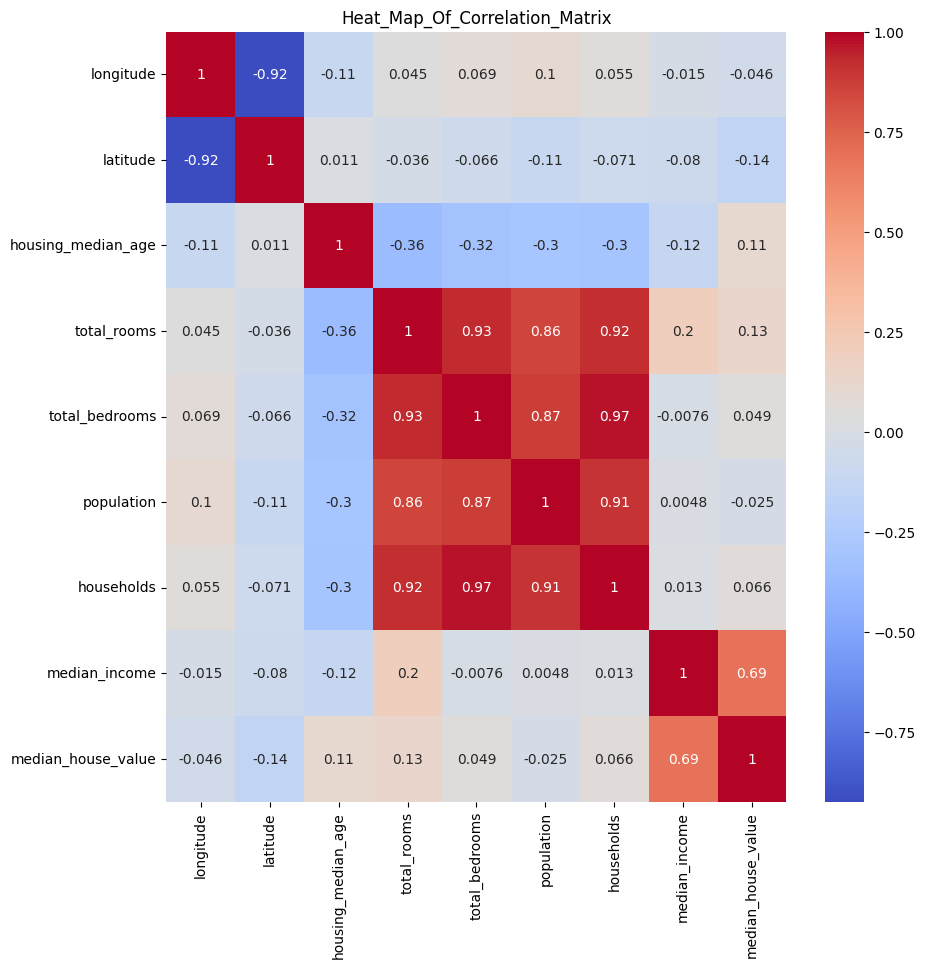

In [ ]:
corr_matrix  = scaled_numeric_data.corr()
plt.figure(figsize=(10,10))
# plt.imshow(corr_matrix, cmap ='coolwarm',interpolation='nearest') ----- i donot like this plot let's try with sns

sns.heatmap(corr_matrix , annot=True , cmap= 'coolwarm')
plt.title("Heat_Map_Of_Correlation_Matrix")

In [ ]:
def numeric_dataframe(dataframe):
    numeric_df = dataframe.select_dtypes(include ='number')
    return numeric_df

In [ ]:
def plot_scatter_matrix(numeric_dataframe):

    # if i just want to plot some of the attributes then i will make a list of them and will pass it to dataframe in the scatter matrix function
    # attributes = ['A','B']
    # scatter_matrix(dataframe[attributes],figsize = (10,8))
    # i will plot the correcln matrix for all the attributes present in the DataFrame
    scatter_matrix(numeric_dataframe,figsize=(10,15),hist_kwds={'bins': 20},alpha =0.5,diagonal='kde')

In [ ]:
numeric_df = numeric_dataframe(df)
# plot_scatter_matrix(numeric_df)

In [ ]:
#now for non-numeric columns i need  one hot encoding
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output = False)

ocean_proximity  = df[['ocean_proximity']]
# non_numeric = encoder.fit_transform(ocean_proximity)
# non_numeric is a sparse matrix (which stores the location of category =1 , it is efficent way of utilixing
#memory when dataset is very large , by default sparse = true ,if we do sparse = False then this(variable) will be a dense matrix )
# use OneHotEncoder (sparse_output = False) to get a dense matrix
non_numeric = encoder.fit_transform(ocean_proximity)
encoding_columns = encoder.get_feature_names_out(['ocean_proximity'])# to get the names of column , we need it when we make DataFrame and concatenate the value with the numeric values
non_numeric = pd.DataFrame(non_numeric,columns = ['less_than1H_ocean','INLAND','ISLAND','NEAR_BAY','NEAR_OCEAN'])


In [ ]:
new_df = pd.concat([non_numeric,scaled_numeric_data],axis =1)
new_df

,less_than1H_ocean,INLAND,ISLAND,NEAR_BAY,NEAR_OCEAN,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,0.0,0.0,0.0,1.0,0.0,-1.327835,1.052548,0.982143,-0.804819,-0.972476,-0.974429,-0.977033,2.344766,2.129631
1,0.0,0.0,0.0,1.0,0.0,-1.322844,1.043185,-0.607019,2.045890,1.357143,0.861439,1.669961,2.332238,1.314156
2,0.0,0.0,0.0,1.0,0.0,-1.332827,1.038503,1.856182,-0.535746,-0.827024,-0.820777,-0.843637,1.782699,1.258693
3,0.0,0.0,0.0,1.0,0.0,-1.337818,1.038503,1.856182,-0.624215,-0.719723,-0.766028,-0.733781,0.932968,1.165100
4,0.0,0.0,0.0,1.0,0.0,-1.337818,1.038503,1.856182,-0.462404,-0.612423,-0.759847,-0.629157,-0.012881,1.172900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,0.0,1.0,0.0,0.0,0.0,-0.758826,1.801647,-0.289187,-0.444985,-0.388283,-0.512592,-0.443449,-1.216128,-1.115804
20636,0.0,1.0,0.0,0.0,0.0,-0.818722,1.806329,-0.845393,-0.888704,-0.922403,-0.944405,-1.008420,-0.691593,-1.124470
20637,0.0,1.0,0.0,0.0,0.0,-0.823713,1.778237,-0.924851,-0.174995,-0.123608,-0.369537,-0.174042,-1.142593,-0.992746
20638,0.0,1.0,0.0,0.0,0.0,-0.873626,1.778237,-0.845393,-0.355600,-0.304827,-0.604429,-0.393753,-1.054583,-1.058608


In [ ]:
Y = new_df['median_house_value']
print(new_df.columns)
X = new_df.drop(columns = ['median_house_value'])


Index(['less_than1H_ocean', 'INLAND', 'ISLAND', 'NEAR_BAY', 'NEAR_OCEAN',
       'longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')


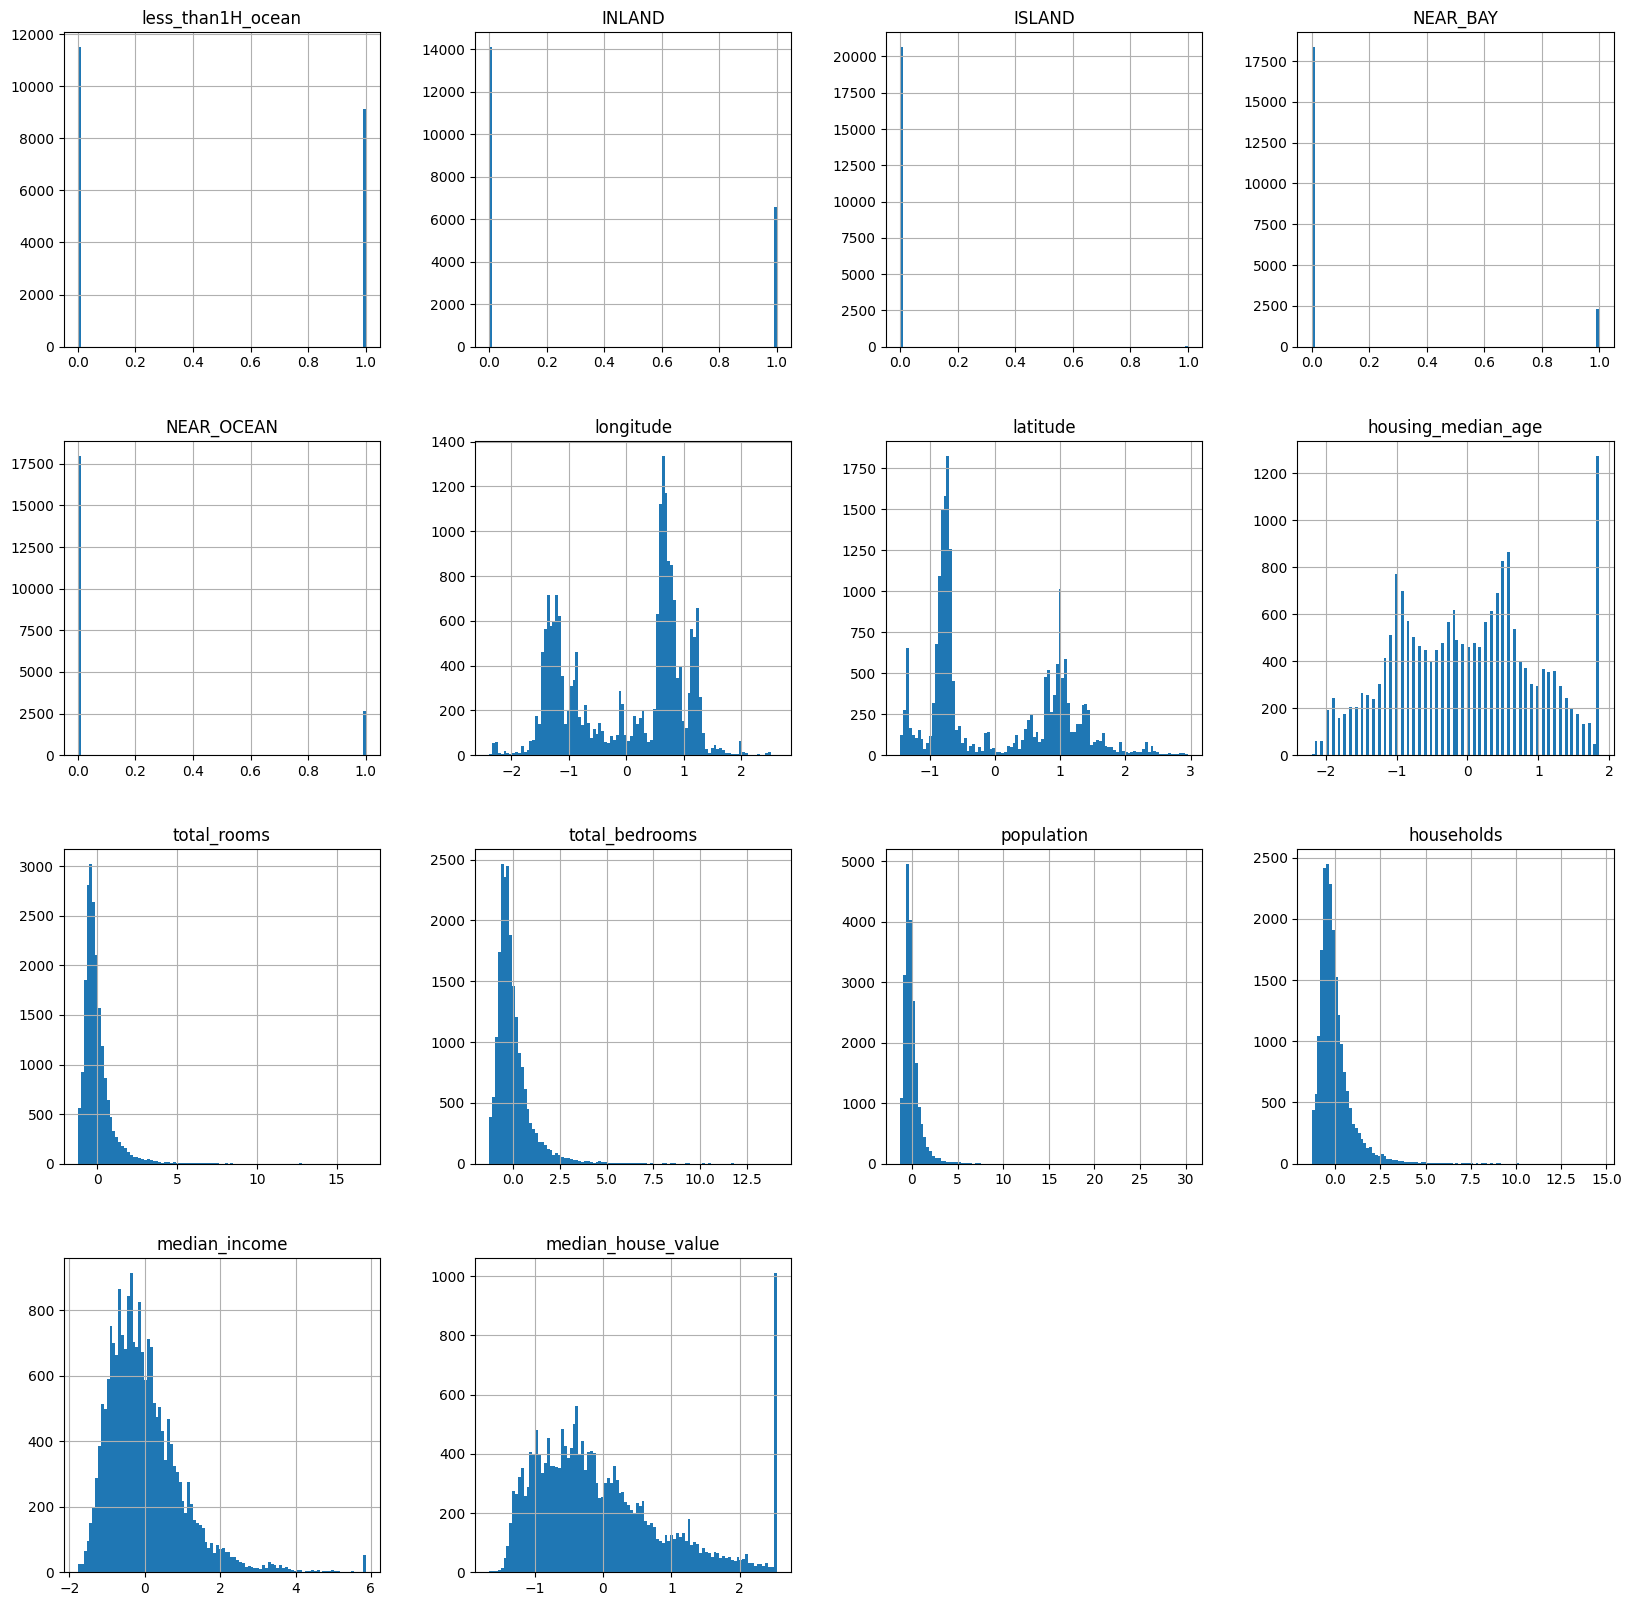

In [ ]:
new_df.hist(bins =100,figsize=(20,20));

In [ ]:

x_train , x_test , y_train , y_test = train_test_split(X,Y,train_size= 0.7,random_state=13)
# y_train = y_train.values.reshape(-1,1)# to reshape in 2 dimensional array which have 1 columns
# y_test = y_test.values.reshape(-1,1)
# randomForestClassifer asking for (n,) 1 dimensional array
x_train.isna().sum()

less_than1H_ocean     0
INLAND                0
ISLAND                0
NEAR_BAY              0
NEAR_OCEAN            0
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

In [ ]:
x_test,x_dev,y_test,y_dev = train_test_split(x_test,y_test,test_size = 0.5)
print(x_test.shape,x_dev.shape,y_test.shape ,y_dev.shape)

(3096, 13) (3097, 13) (3096,) (3097,)


In [ ]:

def model_check_cv(X,Y,Model):

    x_train,x_test,y_train, y_test = train_test_split(X,Y,test_size =0.3)
    x_test,x_dev,y_test,y_dev= train_test_split(x_test,y_test,test_size = 0.3)
    print(f" shapes are x_train -{x_train.shape} , y_train-   {y_train.shape}, x_test - {x_test.shape} ,y_test-  {y_test.shape} , x_dev -  {x_dev.shape}   , y_dev -{y_dev.shape}")

    model = Model

    scores = cross_val_score(Model,x_train,y_train,scoring = 'neg_mean_squared_error',cv=10)
    rmse_score = np.sqrt(-scores)

    print("scores : ",rmse_score)
    print("mean : ",rmse_score.mean())
    print("standard_deviation : ",rmse_score.std())

In [ ]:
from xgboost import XGBRegressor
model_check_cv(X,Y,XGBRegressor())

 shapes are x_train -(14448, 13) , y_train-   (14448,), x_test - (4334, 13) ,y_test-  (4334,) , x_dev -  (1858, 13)   , y_dev -(1858,)
scores :  [0.41940189 0.39274958 0.45216587 0.3931357  0.4167185  0.4246401
 0.39376245 0.41682056 0.40297536 0.4202446 ]
mean :  0.41326146207372216
standard_deviation :  0.017509748445035906


In [ ]:
model_check_cv(X,Y,RandomForestRegressor())
print()
print()
model_check_cv(X,Y,LinearRegression())
print()
print()
model_check_cv(X,Y,DecisionTreeRegressor())
print()
print()
model_check_cv(X,Y,SVR())


 shapes are x_train -(14448, 13) , y_train-   (14448,), x_test - (4334, 13) ,y_test-  (4334,) , x_dev -  (1858, 13)   , y_dev -(1858,)
scores :  [0.43893256 0.43347232 0.43393914 0.41307075 0.40726541 0.43713321
 0.45474991 0.41641483 0.40923934 0.45038657]
mean :  0.42946040287633896
standard_deviation :  0.01613235583020075


 shapes are x_train -(14448, 13) , y_train-   (14448,), x_test - (4334, 13) ,y_test-  (4334,) , x_dev -  (1858, 13)   , y_dev -(1858,)
scores :  [0.60564121 0.60471785 0.61155051 0.58098186 0.58999689 0.59049094
 0.61376918 0.59997195 0.58210447 0.59282969]
mean :  0.5972054541132897
standard_deviation :  0.011058162195458151


 shapes are x_train -(14448, 13) , y_train-   (14448,), x_test - (4334, 13) ,y_test-  (4334,) , x_dev -  (1858, 13)   , y_dev -(1858,)
scores :  [0.62446205 0.6269413  0.58622305 0.62681913 0.58765822 0.59621296
 0.62407782 0.57884036 0.61157216 0.57578227]
mean :  0.6038589322553021
standard_deviation :  0.019997319333600858


 shapes ar

In [ ]:
# grid search for Random Forest
random_forest = RandomForestRegressor()
parameter_grid =[{'n_estimators':[330,350,370,390],
                  'max_depth':[29]}]
grid_search = GridSearchCV(random_forest,parameter_grid,cv=5,scoring = 'neg_mean_squared_error',return_train_score=True)
grid_search.fit(x_dev,y_dev)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': [29],
                          'n_estimators': [330, 350, 370, 390]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
grid_search.best_params_

{'max_depth': 29, 'n_estimators': 370}

In [ ]:
# grid serach for Decision Trees
DecisionTreeRegressor()
parameter_grid =[{'max_depth':[10,20,30],
                  'min_samples_leaf':[1,2,10,20,30,40,50,100,800],
                 'max_features':[1,2,5,10,20,30,50,40],
                }]
grid_search = GridSearchCV(DecisionTreeRegressor(),parameter_grid,cv=5,scoring = 'neg_mean_squared_error',return_train_score=True)
grid_search.fit(x_dev,y_dev)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': [10, 20, 30],
                          'max_features': [1, 2, 5, 10, 20, 30, 50, 40],
                          'min_samples_leaf': [1, 2, 10, 20, 30, 40, 50, 100,
                                               800]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
grid_search.best_params_

{'max_depth': 20, 'max_features': 20, 'min_samples_leaf': 20}

In [ ]:
# xg boost regressor hyperparameter
xg_regressor = XGBRegressor()
parameter_grid =[{'learning_rate':[0.0001,0.00001],
                  'max_depth':[29]}]
grid_search = GridSearchCV(xg_regressor,parameter_grid,cv=5,scoring = 'neg_mean_squared_error',return_train_score=True)
grid_search.fit(x_dev,y_dev)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid=[{'learning_rate': [0.0001, 1e-05], 'max_depth': [29]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
grid_search.best_params_

{'learning_rate': 0.0001, 'max_depth': 29}

In [ ]:
####################### i havenot studied SVM so i donot understand its hyperparameters
#grid search for SVM Regressor
# parameter_grid =[{'max_de':[330,350,370,390],
#                   'max_depth':[29]}]
# grid_search = GridSearchCV(SVR(),parameter_grid,cv=5,scoring = 'neg_mean_squared_error',return_train_score=True)
# grid_search.fit(x_dev,y_dev)

In [ ]:
# use this to check the arguments which we can pass for a function

inspect.signature(sns.heatmap)

<Signature (data, *, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)>

In [ ]:

model_check_cv(X,Y,LinearRegression(copy_X=True))



 shapes are x_train -(14448, 13) , y_train-   (14448,), x_test - (4334, 13) ,y_test-  (4334,) , x_dev -  (1858, 13)   , y_dev -(1858,)
scores :  [0.60088937 0.61157763 0.64036732 0.58885288 0.55584334 0.60131347
 0.55057066 0.60789968 0.61831483 0.57188135]
mean :  0.5947510539608911
standard_deviation :  0.02682608590580478


In [ ]:
def plot_learning_curves(model,x_train,x_dev,y_train,y_dev):
    train_errors,dev_errors = [],[]
    for m in range(1,len(x_train)):
        model.fit(x_train[:m],y_train[:m])
        y_train_predict = model.predict(x_train[:m])
        y_dev_predict = model.predict(x_dev)
        train_errors.append(mean_squared_error(y_train[:m],y_train_predict))
        dev_errors.append(mean_squared_error(y_dev,y_dev_predict))
    plt.plot(np.sqrt(train_errors),'r-+',linewidth = 2,label ='train')
    plt.plot(np.sqrt(dev_errors),'b-',linewidth = 3,label ='dev')
    plt.legend()


In [ ]:
def modified_less_iteration_plot_learning_curves(model,x_train,x_dev,y_train,y_dev):
    train_errors,dev_errors = [],[]
    for m in range(1,len(x_train)):
        model.fit(x_train[:m],y_train[:m])
        y_train_predict = model.predict(x_train[:m])
        y_dev_predict = model.predict(x_dev)
        train_errors.append(mean_squared_error(y_train[:m],y_train_predict))
        dev_errors.append(mean_squared_error(y_dev,y_dev_predict))
    plt.plot(np.sqrt(train_errors),'r-+',linewidth = 2,label ='train')
    plt.plot(np.sqrt(dev_errors),'b-',linewidth = 3,label ='dev')
    plt.legend()

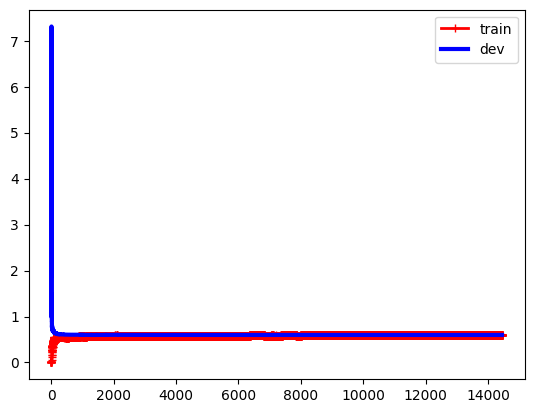

In [ ]:
plot_learning_curves(LinearRegression(),x_train,x_dev,y_train,y_dev)

In [ ]:
plot_learning_curves(RandomForestRegressor(n_estimators =29, max_depth=  270),x_train,x_dev,y_train,y_dev)

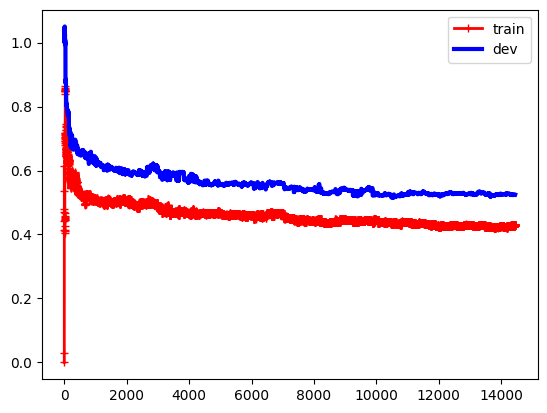

In [ ]:
plot_learning_curves(DecisionTreeRegressor(max_depth = 20 , max_features = 20 , min_samples_leaf = 20 ),x_train,x_dev,y_train,y_dev)


In [ ]:
plot_learning_curves(XGBRegressor(learning_rate = 0.0001, max_depth= 29),x_train,x_dev,y_train,y_dev)